In [1]:
%matplotlib inline
import msprime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import multiprocessing

from IPython.display import SVG

## Setting up a simple ABC inference scheme

The analytical challenges of deriving likelihood functions even under highly idealized models of population structure and history have led to the development of likelihood-free inference methods, in particular Approximate Bayesian Computation (ABC) (Beaumont 2002). ABC approximates the posterior distribution of model parameters by drawing from simulations. Because of its flexibility ABC has become a standard inference tool in statistical population genetics.

We will demonstrate how msprime can be used to set up an ABC inference by means of a simple toy example. We stress that this is meant as an illustration rather than a inference tool for practical use. However, given the flexibility of msprime, we hope to that it should be relatively straighforward to implement more realistic framework focussed on specific inference applications.

We assume that data for 200 loci or sequence blocks (these could be RAD loci in practice) for a single diploid individual have been generated from each of two populations. We would like to infer the amount of gene flow between the two populations. For the sake of simplicity we will assume the simplest possible model of population structure; that is two populations, each of the same effective size that exchange migrants at a constant rate of $M=4 N_e m$ migrants per generation. 

The function ``run_sims`` simulates a dataset consisting of a specified number of loci (``num_loci``) given a migration rate $m$. We generate a single dataset of 50 loci assuming a migration rate $m=0.3$, which we will use as a (pseudo)observed dataset in the ABC implementation.

In [2]:
nsamp = 2
theta = 2
true_m = 0.3
num_loci = 200

def run_sims(m, num_loci=1,theta=0):    
    return msprime.simulate(
        Ne=1/2,
        population_configurations=[
            msprime.PopulationConfiguration(sample_size=nsamp),
            msprime.PopulationConfiguration(sample_size=nsamp)],        
        migration_matrix=[[0, m], [m, 0]],
        num_replicates=num_loci, 
        mutation_rate=theta / 2)

def get_joint_site_frequency_specta(reps):
    data = np.zeros((num_loci, nsamp + 1, nsamp + 1))
    for rep_index, ts in enumerate(reps):
        # Track the samples from population 0.
        for tree in ts.trees(tracked_samples=[0, 1]):            
            for site in tree.sites():
                assert len(site.mutations) == 1
                mutation = site.mutations[0]           
                nleaves0 = tree.num_tracked_samples(mutation.node)
                nleaves1 = tree.num_samples(mutation.node) - nleaves0                
                data[rep_index, nleaves0, nleaves1] += 1            
    return data

truth = get_joint_site_frequency_specta(
    run_sims(true_m, num_loci=num_loci, theta=2))

The ``run_sims`` function returns an iterator with the complete tree sequence and mutational information of each locus. We use the function ``get_joint_site_frequency_specta`` to summarize the polymorphism information as the joint site frequency spectrum (jSFS) of each locus, i.e. the blockwise site frequency spectrum bSFS (sensu Lohse et al 2016). Since msprime simulates rooted trees, the columns and rows of the unfolded jSFS correspond to the frequency of derived mutations in each population and the entries of the jSFS are simply mutation counts. E.g. for the first locus we have:

In [3]:
print("jSFS counts, first locus =")
print(truth[0])

jSFS counts, first locus =
[[ 0.  0.  1.]
 [ 0.  0.  0.]
 [ 2.  0.  0.]]


One could base inference on the bSFS (Lohse 2016 et al, Beeravolou et al 2017), but we will for the sake of simplicity use a simpler (and lossy) summary of the data: the average jSFS across loci. For analyses based on SNPs it is convient to normalize the jSFS by the total number of mutations:

In [4]:
truth_mean = np.mean(truth, axis=0)
truth_mean /= np.sum(truth_mean)
print("mean jSFS =")
print(truth_mean)

mean jSFS =
[[ 0.          0.29832347  0.16617357]
 [ 0.20414201  0.04240631  0.04832347]
 [ 0.16962525  0.07100592  0.        ]]


To illustrate a simple ABC inference scheme, we will focus on a single parameter of interest, the migration rate $m$.

ABC measures the fit of data simulated under the prior to the observed data via a vector of summary statistics. We will use the jSFS as a summary statistic and approximate the jSFS for each $m$ value as the mean length of genealogical branches (as in the bottleneck section above) across 100 simulation replicates (``num_reps``). Below we draw 10,000 $m$ values from the prior and use the function ``run_sims`` and ``approx_jSFS`` to approximate the jSFS for each. We assume an exponential distribution, a common choice of prior (Hey & Wakeley 2002). 

Note that higher level population genetic summaries, e.g.\ pairwise measures of divergence and diversity such as $D_{XY}$ (Nei 1987) and $F_{ST}$ (Wright 1950) or multi-population $F$ statistics (Durand et al 2011, Patterson 2012) which are often used in ABC inference are just further (and lossy) summaries of the jSFS.

In [5]:

num_reps = 100
num_prior_draws = 10000
prior_m = np.random.exponential(0.1, num_prior_draws)

def approx_jSFS(m):
    reps = run_sims(m, num_loci=num_reps)
    B = np.zeros((num_reps, nsamp + 1, nsamp + 1))
    for rep_index, ts in enumerate(reps):        
        samp1 = ts.samples(population_id=0)
        for tree in ts.trees(tracked_samples=samp1):
            # Note that this will be inefficient if we have lots of trees. Should
            # use an incremental update strategy using edge_diffs in this case.
            for u in tree.nodes():
                nleaves1 = tree.num_tracked_samples(u)
                nleaves2 = tree.num_samples(u) - nleaves1
                if tree.parent(u) != msprime.NULL_NODE:
                    B[rep_index, nleaves1, nleaves2] += tree.branch_length(u)
    data = np.mean(B, axis=0)        
    return data / np.sum(data)

with multiprocessing.Pool() as pool:
    prior_jSFS = pool.map(approx_jSFS, prior_m)

print(prior_jSFS[0])

[[ 0.          0.10743359  0.3748975 ]
 [ 0.0862899   0.00068621  0.01690864]
 [ 0.37406319  0.03972095  0.        ]]


We compute the Euclidean distance between the estimated jSFS for each draw from the prior (prior_jSFS) and the jSFS in the (pseudo)observed data (truth_mean):

In [6]:
distances = np.zeros(num_prior_draws)
for j in range(num_prior_draws):
    distances[j] = np.sqrt(np.sum((prior_jSFS[j] - truth_mean)**2))

In its simplest form, ABC approximates the posterior by sampling from the simulated data via an acceptance threshold. Here we approximate the posterior distribution of $m$ from the 5% of simulation replicates that most closely match the jSFS of the observed data. The posterior distribution (shown in green) is centred around $m=0.25$.

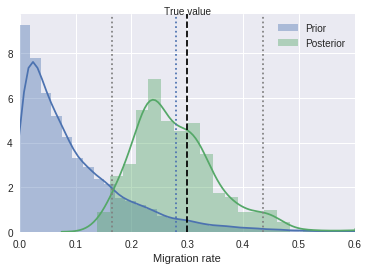

In [7]:
cutoff = np.percentile(distances, 5)
keep = np.where(distances < cutoff)
post_m = prior_m[keep]
mean_m = np.mean(post_m)
ci_m = np.percentile(post_m, 2.5), np.percentile(post_m, 95.75)
sns.distplot(prior_m, label="Prior")
sns.distplot(post_m, label="Posterior")
plt.xlabel("Migration rate");
plt.axvline(x=true_m, ls="--", color="black")
plt.axvline(x=mean_m, ls=":")
plt.axvline(x=ci_m[0], ls=":", color="grey")
plt.axvline(x=ci_m[1], ls=":", color="grey")
plt.text(true_m, plt.ylim()[1], "True value", horizontalalignment="center")
plt.xlim(0, 0.6)
plt.legend();

The mean and the 95% approximate posterior credible interval for $m$ are:

In [8]:
print([mean_m, ci_m])

[0.27899421286273213, (0.16471502629282914, 0.43559238241989584)]


## Cross-validation using pseudoobserved data sets

A question that commonly arises in the context of ABC is how much power/information we can expect about a particular parameter. A straightforward cross-validation procedure consists of repeating the inference on pseudoobserved data sets (PODS) generated under a known truth. Since we can use re-use the same set of simulation replicates for inference, this is computationally efficient. Here we generate 100 POD, each consisting of 200 loci for $m=0.3$ and store the corresponding jSFS as an array (data_pseudo_obs):

In [9]:
num_loci = 200
num_pseudo_obs = 100
data_pseudo_obs = np.zeros((num_pseudo_obs, nsamp+1, nsamp+1))
for j in range(num_pseudo_obs):   
    data = get_joint_site_frequency_specta(
        run_sims(true_m, num_loci=num_loci, theta=2))
    data_mean = np.mean(data, axis=0)
    data_pseudo_obs[j] = data_mean / np.sum(data_mean)

We record the mean posterior estimate of $m$ for each PODS. The standard deviation (SD) of $m$ estimates across PODS is 0.04. We can use this to obtain an approximate estimate of the 95% posterior credibility interval (+/- 2SD), which is slightly narrower than the 95% posterior credibility interval estimated from the posterior distribution of a single PODS above.

In [10]:
mean_ests = np.zeros(num_pseudo_obs)
for k in range(num_pseudo_obs):
    distances = np.zeros(num_prior_draws)
    for j in range(num_prior_draws):
        distances[j] = np.sqrt(np.sum((data_pseudo_obs[k] - prior_jSFS[j])**2))
    keep = np.where(distances < cutoff)
    mean_ests[k] = np.mean(prior_m[keep])

[0.26841062799969878, [0.20156575611080468, 0.33525549988859288]]


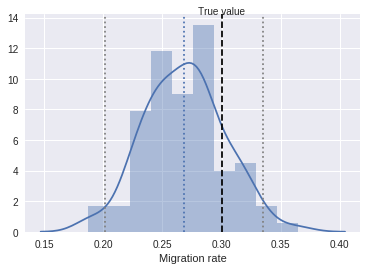

In [11]:
meanmPODS=np.mean(mean_ests)
SDmPODS=np.std(mean_ests)
print([meanmPODS, [meanmPODS - 2 * SDmPODS, meanmPODS + 2*SDmPODS]])
sns.distplot(mean_ests)
plt.xlabel("Migration rate");
plt.axvline(x=true_m, ls="--", color="black")
plt.axvline(x=meanmPODS, ls=":")
plt.axvline(x=meanmPODS - 2*SDmPODS, ls=":", color="grey")
plt.axvline(x=meanmPODS + 2*SDmPODS, ls=":", color="grey")
plt.text(true_m, plt.ylim()[1], "True value", horizontalalignment="center");

Although the true value of of $m=0.3$ is contained within the 95 % credible interval, the posterior distribution is clearly downwardly biased. This bias is expected given that our prior is biased towards low $m$. We can check the effect the acceptance threshold has on the inference, by computing the root-mean-square error (RMSE) for a range of thresholds:

In [12]:
cutoffs = np.array([0.675,1.25,2.5,5,10,20])
len_c = len(cutoffs)

mean_ests = np.zeros((len_c,num_pseudo_obs))
for i in range(len_c):          
    for k in range(num_pseudo_obs):
        distances = np.zeros(num_prior_draws)
        for j in range(num_prior_draws):
            distances[j] = np.sqrt(np.sum((data_pseudo_obs[k] - prior_jSFS[j])**2))
        cutoff=np.percentile(distances, cutoffs[i])
        keep = np.where(distances < cutoff)
        mean_ests[i][k] = np.mean(prior_m[keep])

In [13]:
mean_m = np.mean(mean_ests, axis=1)
mean_square_err = np.zeros((len_c,num_pseudo_obs))
for i in range(len_c):
    for k in range(num_pseudo_obs):
        mean_square_err[i][k] = (mean_ests[i][k] - true_m)**2
mean_square_err_fin =[np.sqrt(np.sum(mean_square_err[i])) for i in range(len_c)]

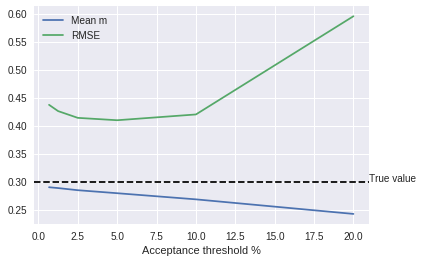

In [14]:
plt.plot(cutoffs, mean_m, label="Mean m");
plt.plot(cutoffs, mean_square_err_fin, label="RMSE")
plt.xlabel("Acceptance threshold %")
plt.axhline(y=true_m, ls="--", color="black")
plt.text(plt.xlim()[1], true_m, "True value")
plt.legend();

Ploting the mean and the RMSE against the acceptance threshold shows that both the downward bias in $m$ estimates and the associated RMSE increase with larger acceptance tresholds as expected. However, sampling only a small farction of simulations generated under the prior is computationally inefficient and more efficient sampling strategies for ABC inference have been developed (Beaumont 2002). While this toy example illustrates the principle of ABC, in practice we are generally interested in fitting parameter-rich models and it would be straightforward to implement ABC inference for complex model of population structure and demography in msprime.